In [47]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations

In [48]:
df_food = pd.read_csv("df_food_filtered_with_food_group.csv",index_col=0)
with open("df_food_openfoodfacts_merged.pkl", "rb") as f:
    df_food_openfoodfacts = pickle.load(f, encoding="latin1")

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11188\1585345951.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv("df_food_filtered_with_food_group.csv",index_col=0)


In [49]:
df_food = df_food[df_food["eaten_quantity_in_gram"] > 0]
df_food = df_food[df_food["energy_kcal_eaten"] > 0]

In [50]:
nutrient_info = {
    'folate_eaten':                                         {'unit': 'mcg', 'target': 400,  'type': 'qualifying'},
    'niacin_eaten':                                         {'unit': 'mg',  'target': 14,   'type': 'qualifying'},
    'pantothenic_acid_eaten':                               {'unit': 'mg',  'target': 5,    'type': 'qualifying'},
    'vitamin_b2_eaten':                                     {'unit': 'mg',  'target': 1.1,  'type': 'qualifying'},
    'vitamin_b1_eaten':                                     {'unit': 'mg',  'target': 1.2,  'type': 'qualifying'},
    'all_trans_retinol_equivalents_activity_eaten':         {'unit': 'IU',  'target': 700,  'type': 'qualifying'},
    'beta_carotene_eaten':                                  {'unit' : 'mcg','target' : 700, 'type' :'qualifying'},
    'vitamin_b12_eaten':                                    {'unit': 'mcg', 'target': 2.4,  'type': 'qualifying'},
    'vitamin_b6_eaten':                                     {'unit': 'mg',  'target': 1.3,  'type': 'qualifying'},
    'vitamin_c_eaten':                                      {'unit': 'mg',  'target': 75,   'type': 'qualifying'},
    'vitamin_d_eaten':                                      {'unit': 'mcg', 'target': 7.5,  'type': 'qualifying'},
    'vitamin_e_activity_eaten':                             {'unit': 'TAE', 'target': 15,    'type': 'qualifying'},
    'calcium_eaten':                                        {'unit': 'mg',  'target': 1000, 'type': 'qualifying'},
    'iron_eaten':                                           {'unit': 'mg',  'target': 18,   'type': 'qualifying'},
    'magnesium_eaten':                                      {'unit': 'mg',  'target': 320,  'type': 'qualifying'},
    'phosphorus_eaten':                                     {'unit': 'mg',  'target': 700,  'type': 'qualifying'},
    'potassium_eaten':                                      {'unit': 'mg',  'target': 4700, 'type': 'qualifying'},
    'zinc_eaten':                                           {'unit': 'mg',  'target': 8,    'type': 'qualifying'},
    'fiber_eaten':                                          {'unit': 'g',   'target': 25,   'type': 'qualifying'},
    'protein_eaten':                                        {'unit': 'g',   'target': 46,   'type': 'qualifying'},
    'fat_eaten':                                            {'unit': 'g',   'target': 78,   'type': 'disqualifying'},
    'fatty_acids_saturated_eaten':                          {'unit': 'g',   'target': 22,   'type': 'disqualifying'},
    'cholesterol_eaten':                                    {'unit': 'mg',  'target': 300,  'type': 'disqualifying'},
    'sugar_eaten':                                          {'unit': 'g',   'target': 125,  'type': 'disqualifying'},
    'sodium_eaten':                                         {'unit': 'mg',  'target': 2400, 'type': 'disqualifying'},
    'salt_eaten' :                                          {'unit' : 'g',  'target': 6,   'type': 'disqualifying'}
}


conversion_factors = {
    "mg": 1000,
    "g": 1,
    "mcg": 1000000,
    "IU": 1,
    "TAE": 1,
}

In [51]:
qualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'qualifying'}
disqualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'disqualifying'}

In [52]:
def calculate_ratios(df, nutrient_cols):
    df = df.copy()

    for nutr in nutrient_cols:
        conversion_factor = conversion_factors[nutrient_info[nutr]['unit']]

        df[nutr + '_ratio'] = df[nutr] * conversion_factor / nutrient_info[nutr]['target']

    return df

df_food_ratio = calculate_ratios(df_food.fillna(0), list(nutrient_info.keys()))

In [86]:
df_food_ratio.describe()

,food_id,dish_id,eaten_quantity,eaten_at_utc_offset,media_count,fallback_food_id,standard_portion_quantity,specific_gravity,alcohol,all_trans_retinol_equivalents_activity,...,protein_eaten_ratio,fat_eaten_ratio,fatty_acids_saturated_eaten_ratio,cholesterol_eaten_ratio,sugar_eaten_ratio,sodium_eaten_ratio,salt_eaten_ratio,QI,DI,NB
count,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,...,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000,317780.000000
mean,2960.136056,205447.454720,60.336813,94.096041,0.827680,190.904594,73.409149,0.000473,0.314320,44.279484,...,0.086370,0.057891,0.074842,0.042935,0.029102,0.058396,0.036103,2.806061,1.083996,40.499099
std,4094.972611,125854.699478,70.699020,37.354649,0.377659,721.153330,69.880747,0.022610,2.076871,245.160857,...,0.153958,0.088950,0.145757,0.165099,0.054352,0.127527,0.099142,9.302761,2.472317,29.152658
min,13.000000,642.000000,0.006300,-420.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1212.000000,95565.750000,10.000000,60.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,...,0.005652,0.001538,0.000000,0.000000,0.000960,0.000481,0.000000,0.169437,0.435192,10.000000
50%,2022.000000,193739.000000,40.000000,120.000000,1.000000,0.000000,50.000000,0.000000,0.000000,0.000000,...,0.030435,0.016154,0.010909,0.000000,0.007400,0.003750,0.000000,0.733118,0.683990,39.193594
75%,2741.000000,328554.250000,100.000000,120.000000,1.000000,0.000000,110.000000,0.000000,0.000000,0.000000,...,0.102826,0.084615,0.085364,0.000667,0.032480,0.064167,0.015000,2.098087,1.147985,66.815902
max,46590.000000,428329.000000,3000.000000,240.000000,1.000000,10626.000000,400.000000,1.100000,45.683100,13900.000000,...,4.686957,2.310897,6.227273,5.384800,4.200000,16.800000,4.583333,608.951325,289.650695,100.000000


In [54]:
def scale(df, nutrient_cols, scaling_factor=2000):
    df = df.copy()

    for nutr in nutrient_cols:

        df[nutr + "_ratio_scaled"] = df[nutr + '_ratio']* (scaling_factor / df["energy_kcal_eaten"])
     

    return df

In [55]:
df_food_scaled = scale(df_food_ratio.fillna(0), list(nutrient_info.keys()), scaling_factor=2000)

In [56]:
df_food_scaled

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,potassium_eaten_ratio_scaled,zinc_eaten_ratio_scaled,fiber_eaten_ratio_scaled,protein_eaten_ratio_scaled,fat_eaten_ratio_scaled,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled
0,13,0,335994,110.00,g,bjsqab,2022-02-15 18:06:27,60,1,dairy_products_meat_fish_eggs_tofu,...,0.856776,7.214765,0.000000,7.936971,0.774393,1.037218,3.93736,0.000000,0.430649,0.000000
3,13,0,411384,100.00,g,erv9jd,2023-01-18 13:08:53,60,1,dairy_products_meat_fish_eggs_tofu,...,0.856776,7.214765,0.000000,7.936971,0.774393,1.037218,3.93736,0.000000,0.430649,0.000000
4,25,0,202497,35.00,g,6ata8r,2021-03-30 13:52:23,120,1,vegetables_fruits,...,1.084689,0.490196,2.196078,0.341006,0.100553,0.000000,0.00000,3.545098,0.032680,0.000000
5,25,0,283397,35.00,g,uzbc9s,2021-10-21 10:09:09,120,1,vegetables_fruits,...,1.084689,0.490196,2.196078,0.341006,0.100553,0.000000,0.00000,3.545098,0.032680,0.000000
6,25,0,266679,40.00,g,fvh6kf,2021-09-19 10:14:35,120,1,vegetables_fruits,...,1.084689,0.490196,2.196078,0.341006,0.100553,0.000000,0.00000,3.545098,0.032680,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514955,46573,4104420237155,426463,16.00,g,pgeyqb,2023-03-13 15:16:39,60,0,unclassified,...,0.000000,0.000000,0.886544,0.917747,0.202963,0.263852,0.00000,0.633245,0.000000,0.026385
514956,46573,4104420237155,426838,16.00,g,pgeyqb,2023-03-13 15:30:54,60,0,unclassified,...,0.000000,0.000000,0.886544,0.917747,0.202963,0.263852,0.00000,0.633245,0.000000,0.026385
514957,46575,5411188102809,423445,100.00,g,kmxhmz,2023-02-25 08:18:11,60,1,unclassified,...,0.000000,0.000000,1.315068,2.144133,0.702494,0.373599,0.00000,2.060274,0.000000,0.958904
514958,46588,7618500940806,425332,100.00,ml,pgeyqb,2023-03-06 18:31:08,60,1,unclassified,...,0.000000,0.000000,0.000000,1.185771,0.000000,0.000000,0.00000,2.909091,0.000000,15.151515


In [57]:
def compute_index(row, nutrient_cols, scaling_factor=2000) :

    index = 0
    ratio_sum = 0

    for nutr in nutrient_cols :
        ratio_sum += row[nutr + '_ratio']

    index = (scaling_factor / row['energy_kcal_eaten']) * (ratio_sum / len(nutrient_cols))
    return index

In [58]:
def compute_nb(row, nutrient_cols, scaling_factor=2000) :
    truncated_ratios = []
    for nutr in nutrient_cols:
        ratio =   row[nutr + '_ratio_scaled']
        if ratio > 1.0 :
            ratio = 1
        truncated_ratios.append(ratio)

    nb_value =  (sum(truncated_ratios) / len(nutrient_cols)) * 100
    return nb_value

In [59]:
df_food_ratio['QI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=qualifying_nutrients)
df_food_scaled['QI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=qualifying_nutrients)

In [60]:
df_food_ratio['DI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=disqualifying_nutrients)
df_food_scaled['DI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=disqualifying_nutrients)

In [62]:
df_food_ratio['NB'] = df_food_scaled.apply(compute_nb, axis=1, nutrient_cols=qualifying_nutrients)
df_food_scaled['NB'] = df_food_scaled.apply(compute_nb, axis=1, nutrient_cols=qualifying_nutrients)

In [63]:
df_food_scaled.to_csv('df_food_scaled.csv', index=False)

In [64]:
df_food_ratio

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_ratio,fat_eaten_ratio,fatty_acids_saturated_eaten_ratio,cholesterol_eaten_ratio,sugar_eaten_ratio,sodium_eaten_ratio,salt_eaten_ratio,QI,DI,NB
0,13,0,335994,110.00,g,bjsqab,2022-02-15 18:06:27,60,1,dairy_products_meat_fish_eggs_tofu,...,0.650435,0.063462,0.085000,0.322667,0.00000,0.035292,0.000000,2.498497,1.029937,67.110660
3,13,0,411384,100.00,g,erv9jd,2023-01-18 13:08:53,60,1,dairy_products_meat_fish_eggs_tofu,...,0.591304,0.057692,0.077273,0.293333,0.00000,0.032083,0.000000,2.498497,1.029937,67.110660
4,25,0,202497,35.00,g,6ata8r,2021-03-30 13:52:23,120,1,vegetables_fruits,...,0.003043,0.000897,0.000000,0.000000,0.03164,0.000292,0.000000,1.047794,0.613055,61.770389
5,25,0,283397,35.00,g,uzbc9s,2021-10-21 10:09:09,120,1,vegetables_fruits,...,0.003043,0.000897,0.000000,0.000000,0.03164,0.000292,0.000000,1.047794,0.613055,61.770389
6,25,0,266679,40.00,g,fvh6kf,2021-09-19 10:14:35,120,1,vegetables_fruits,...,0.003478,0.001026,0.000000,0.000000,0.03616,0.000333,0.000000,1.047794,0.613055,61.770389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514955,46573,4104420237155,426463,16.00,g,pgeyqb,2023-03-13 15:16:39,60,0,unclassified,...,0.027826,0.006154,0.008000,0.000000,0.01920,0.000000,0.000800,0.090215,0.187741,9.021452
514956,46573,4104420237155,426838,16.00,g,pgeyqb,2023-03-13 15:30:54,60,0,unclassified,...,0.027826,0.006154,0.008000,0.000000,0.01920,0.000000,0.000800,0.090215,0.187741,9.021452
514957,46575,5411188102809,423445,100.00,g,kmxhmz,2023-02-25 08:18:11,60,1,unclassified,...,0.078261,0.025641,0.013636,0.000000,0.07520,0.000000,0.035000,0.952744,0.682545,30.000000
514958,46588,7618500940806,425332,100.00,ml,pgeyqb,2023-03-06 18:31:08,60,1,unclassified,...,0.013043,0.000000,0.000000,0.000000,0.03200,0.000000,0.166667,0.786561,3.010101,10.000000


In [65]:
df_food_scaled[['QI', 'DI','NB', 'combined_name', 'food_group']].groupby('food_group').median(numeric_only=True).sort_values('QI')

,QI,DI,NB
food_group,,,
alcoholic_beverages,0.038127,0.007668,3.812709
sweetened_beverages,0.041806,0.664300,4.180602
others,0.105016,0.666667,5.474351
soups_sauces_condiments,0.117561,1.068889,6.402525
salty_snacks,0.121828,0.535766,10.000000
cooked_grains_pasta,0.135563,0.517566,9.358974
sweets_desserts,0.157373,0.852030,12.639102
vegetable_oils,0.245871,0.694173,6.645221
butter_margarine_spreads,0.284294,1.837749,15.794434


In [66]:
df_vegetable = df_food_scaled[df_food_scaled['food_group'] == 'vegetables']

In [67]:
df_vegetable.drop_duplicates('combined_name')

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_ratio_scaled,fat_eaten_ratio_scaled,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled,QI,DI,NB
126,50,0,4055,40.0,g,k3pnhy,2019-02-14 18:57:30,60,1,vegetables_fruits,...,1.449275,0.044984,0.000000,0.0,2.947368,0.847953,0.000000,1.679289,0.640051,69.928989
1066,116,0,100802,25.0,g,upybs2,2020-03-12 18:29:00,60,1,vegetables_fruits,...,4.202899,0.341880,0.303030,0.0,1.173333,0.305556,0.000000,10.154847,0.353967,85.000000
1529,143,0,261362,100.0,g,dradpm,2021-09-06 10:46:40,120,1,vegetables_fruits,...,0.954401,0.187617,0.000000,0.0,2.770732,0.508130,0.000000,26.262483,0.577747,80.530812
2440,148,0,83560,60.0,g,r2wkvx,2019-12-07 21:34:54,60,1,vegetables_fruits,...,2.717391,0.160256,0.000000,0.0,1.600000,5.208333,0.000000,9.101358,1.161432,85.000000
2454,150,0,209797,40.0,g,jb3nq3,2021-04-18 17:09:04,120,1,vegetables_fruits,...,2.318841,0.256410,0.000000,0.0,1.066667,2.361111,0.000000,3.910093,0.614031,85.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513903,33127,7627534181055,385720,52.0,g,kgbtut,2022-09-20 16:42:32,120,0,unclassified,...,1.234568,0.633112,0.561167,0.0,1.362963,0.000000,2.057613,0.204938,0.769143,10.000000
513969,33189,7613312295588,388048,250.0,g,kgbtut,2022-09-26 16:53:22,120,0,unclassified,...,1.708075,0.457875,0.000000,0.0,0.800000,0.000000,7.738095,0.471118,1.499328,10.000000
514352,33518,7627534612115,397015,200.0,g,wjtpa5,2022-11-06 21:49:57,60,0,unclassified,...,4.347826,0.000000,0.000000,0.0,1.333333,0.000000,0.000000,0.684058,0.222222,10.000000
514667,46071,7613312273760,406384,250.0,g,48wbxy,2022-12-08 11:09:58,60,0,unclassified,...,2.879729,0.432900,0.236128,0.0,0.644156,0.000000,1.991342,0.377753,0.550754,10.000000


# Vegetables with QI > 10

In [68]:
high_qi_vegetable = df_vegetable[df_vegetable['QI'] > 10].drop_duplicates('combined_name').sort_values('QI', ascending=False)

In [69]:
high_qi_vegetable[['combined_name', 'eaten_quantity', 'QI', 'DI', 'NB']]

,combined_name,eaten_quantity,QI,DI,NB
484235,Epinards,50.0,40.795386,0.613869,85.000000
4599,"Spinach, raw",35.0,40.795386,0.613869,85.000000
485667,Coop Naturaplan Betty Bossi Organic mung bean ...,100.0,39.742825,1.335664,80.000000
4426,"Chicory, steamed, without addition of salt",80.0,37.913804,0.210058,84.761905
26934,Cress,20.0,36.840014,0.856397,85.000000
4453,"Spinach, steamed, without addition of salt",100.0,35.562131,0.539693,85.000000
463795,Coop Naturaplan Grated carrot,75.0,32.681048,0.690236,82.154882
472765,Bio Karotten Schweizer,120.0,32.681048,0.572643,82.154882
34611,"Salad, lambs' ear",40.0,31.008325,0.396237,83.478261
499389,Coop Qualité&Prix - Nüsslisalat Schweiz,66.0,31.008325,0.396237,83.478261


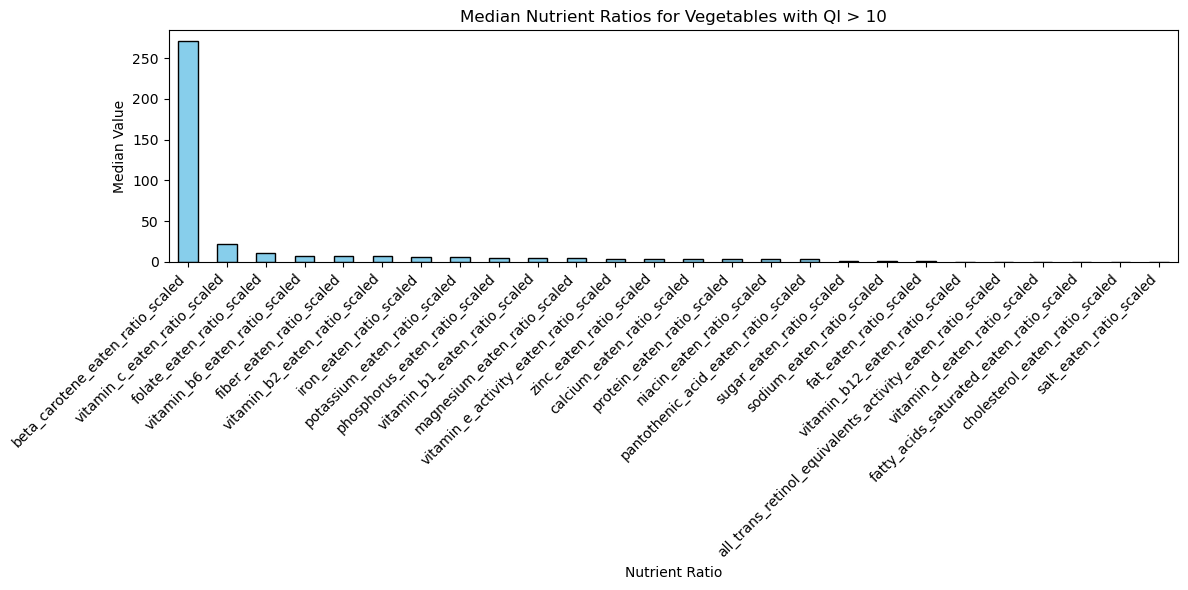

In [70]:
ratio_cols = [i for i in high_qi_vegetable.columns if '_ratio_scaled' in i]
median_ratios = high_qi_vegetable[ratio_cols].median().sort_values(ascending=False)


plt.figure(figsize=(12, 6))
median_ratios.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Median Nutrient Ratios for Vegetables with QI > 10")
plt.xlabel("Nutrient Ratio")
plt.ylabel("Median Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [71]:
df_corr = high_qi_vegetable[ratio_cols + ['QI']]
corr = df_corr.corr()['QI']
corr.sort_values(ascending=True)

vitamin_c_eaten_ratio_scaled                                -0.211816
sugar_eaten_ratio_scaled                                    -0.154857
fat_eaten_ratio_scaled                                      -0.141122
salt_eaten_ratio_scaled                                     -0.066893
pantothenic_acid_eaten_ratio_scaled                         -0.030865
vitamin_d_eaten_ratio_scaled                                -0.023057
niacin_eaten_ratio_scaled                                    0.079278
sodium_eaten_ratio_scaled                                    0.112431
fiber_eaten_ratio_scaled                                     0.152178
protein_eaten_ratio_scaled                                   0.156146
fatty_acids_saturated_eaten_ratio_scaled                     0.183992
vitamin_b2_eaten_ratio_scaled                                0.203663
iron_eaten_ratio_scaled                                      0.252746
vitamin_b6_eaten_ratio_scaled                                0.270396
potassium_eaten_rati

As we can see, the beta carotene is the micronutrient with the most correlation with QI. Magnesium, calcium, folate and vitamin b1 should also be factor to this change

In [72]:
def compute_qi_excluding(row, nutrient_list, exclude=None, scaling_factor=2000):
    if exclude is not None:
        new_list = [nutr for nutr in nutrient_list if nutr != exclude]
    else:
        new_list = nutrient_list
    

    return compute_index(row, new_list, scaling_factor=scaling_factor)

In [73]:
def compare_qi_excluding_nutrient(df, nutrient_to_exclude, qualifying_nutrients, new_col_name=None,scaling_factor=2000):


    if new_col_name is None:
        new_col_name = f"QI_excl_{nutrient_to_exclude}"


    df[new_col_name] = df.apply(lambda row: compute_qi_excluding(row, qualifying_nutrients, exclude=nutrient_to_exclude, scaling_factor=scaling_factor), axis=1)

 
    df_plot = df.drop_duplicates('combined_name').copy()
    df_plot = df_plot[['combined_name', 'QI', new_col_name]]

    labels = df_plot['combined_name'].tolist()
    x = np.arange(len(labels))
    width = 0.35


    plt.figure(figsize=(20, 8))
    plt.bar(x - width/2, df_plot['QI'], width, label='QI (incl. ' + nutrient_to_exclude + ')', color='skyblue')
    plt.bar(x + width/2, df_plot[new_col_name], width, label=f"QI (excl. {nutrient_to_exclude})", color='deeppink')

    plt.xlabel('Food Item')
    plt.ylabel('QI Value')
    plt.title(f"Comparison of QI with and without {nutrient_to_exclude}")
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    df_plot['QI_diff'] = df_plot['QI'] - df_plot[new_col_name]
    df_plot['QI_pct_change'] = (df_plot['QI_diff'] / df_plot['QI']) * 100

    return df_plot

In [74]:
def compute_qi_excluding_multiple(row, nutrient_list, exclude_list, scaling_factor=2000):

    new_list = nutrient_list.copy()  

    for nutr in exclude_list:
        if nutr in new_list:
            new_list.remove(nutr)

    return compute_index(row, new_list, scaling_factor=scaling_factor)



In [75]:
def plot_nutrient_contributions_with_qi(row, nutrient_cols, exclude_list=None, scaling_factor=2000):

    if exclude_list is not None:
        included_nutrients = [nutr for nutr in nutrient_cols if nutr not in exclude_list]
    else:
        included_nutrients = nutrient_cols

    qi_value = compute_index(row, included_nutrients, scaling_factor=scaling_factor)
    
    ratio_cols = [nutr + '_ratio_scaled' for nutr in included_nutrients]

    values = row[ratio_cols]
    
    plt.figure(figsize=(14, 6))
    bars = plt.bar(ratio_cols, values, color='skyblue', edgecolor='skyblue')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.05 * max(values),
                 f"{height:.2f}", ha='center', va='bottom', fontsize=8)
    
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Scaled Nutrient Ratio")
    
 
    if exclude_list is None:
        title_str = f"Nutrient Contributions for {row['combined_name']} \n(QI = {qi_value:.2f})\n"
    else:
        title_str = (f"Nutrient Contributions for {row['combined_name']} \n(Excluding {', '.join(exclude_list)})\n"f"QI = {qi_value:.2f}\n")
    
    plt.title(title_str)
    plt.tight_layout()
    plt.show()

## Beta carotene

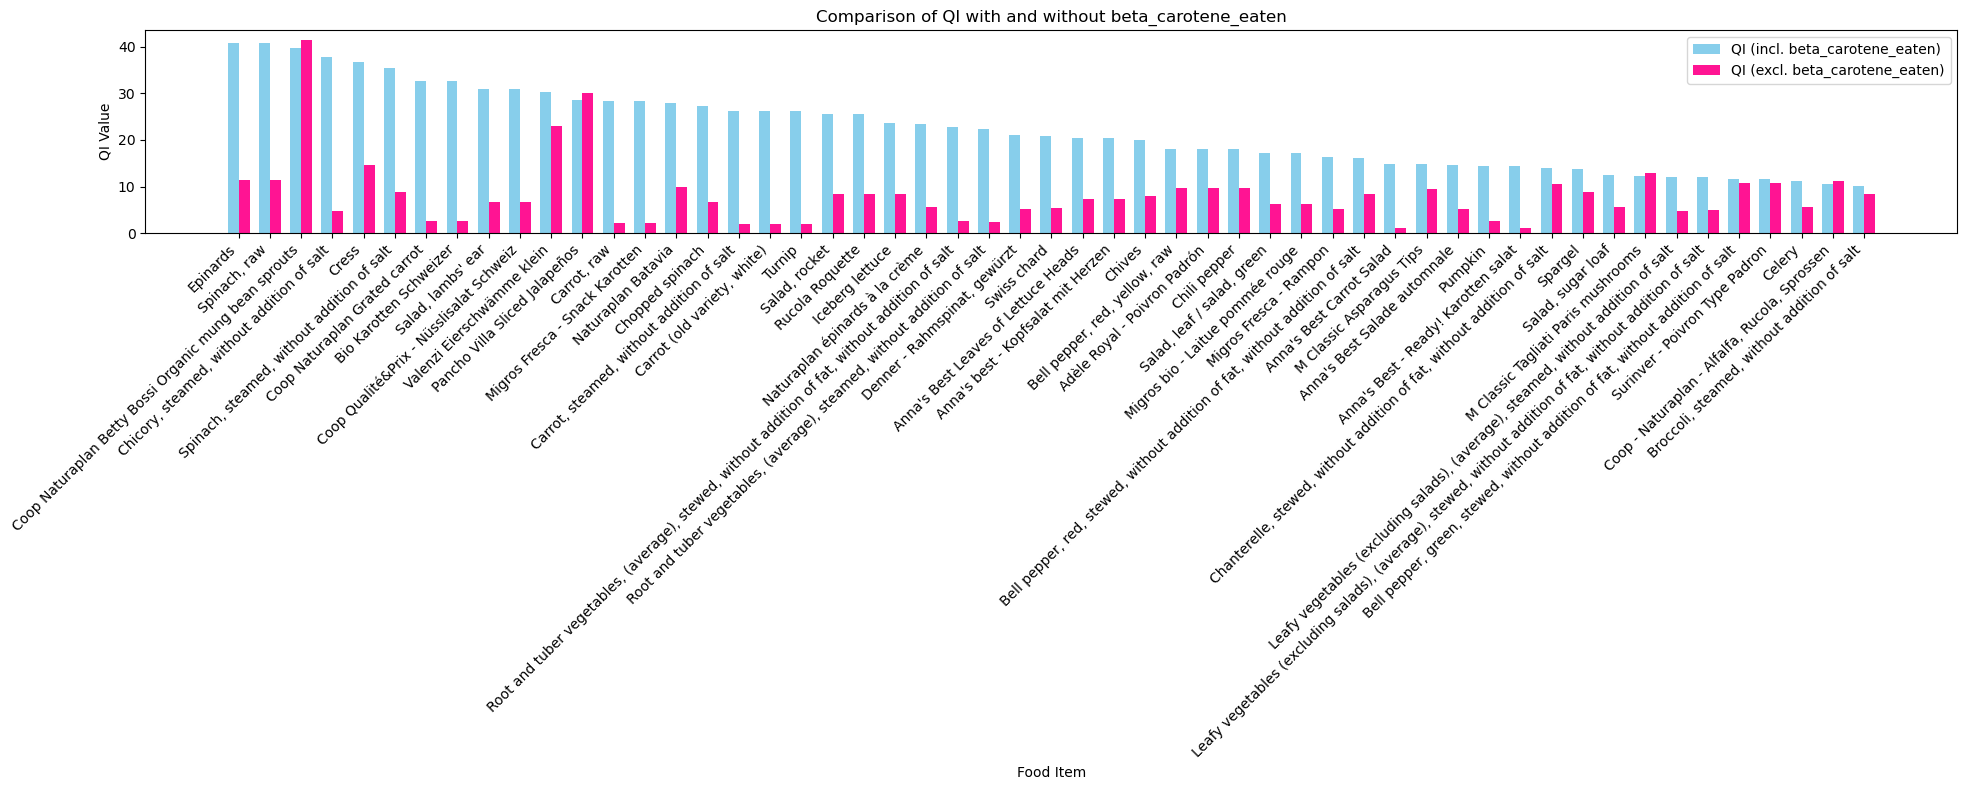

,combined_name,QI,QI_excl_beta_carotene_eaten,QI_diff,QI_pct_change
484235,Epinards,40.795386,11.494326,29.301060,71.824447
4599,"Spinach, raw",40.795386,11.494326,29.301060,71.824447
485667,Coop Naturaplan Betty Bossi Organic mung bean ...,39.742825,41.475964,-1.733139,-4.360885
4426,"Chicory, steamed, without addition of salt",37.913804,4.678333,33.235471,87.660608
26934,Cress,36.840014,14.718811,22.121202,60.046672
4453,"Spinach, steamed, without addition of salt",35.562131,8.862393,26.699737,75.079128
463795,Coop Naturaplan Grated carrot,32.681048,2.507733,30.173315,92.326645
472765,Bio Karotten Schweizer,32.681048,2.507733,30.173315,92.326645
34611,"Salad, lambs' ear",31.008325,6.749528,24.258797,78.233175
499389,Coop Qualité&Prix - Nüsslisalat Schweiz,31.008325,6.749528,24.258797,78.233175


In [76]:
df_vegetable_beta_carotene = compare_qi_excluding_nutrient(df=high_qi_vegetable, nutrient_to_exclude='beta_carotene_eaten', qualifying_nutrients=qualifying_nutrients)

df_vegetable_beta_carotene

Overall, beta-carotene is the micronutrient that most strongly influences the QI value. I tested all the other qualifying nutrients, and they only slightly changed the value, remained the same, or even increased the QI. I will perform a more detailed analysis on specific food items where the elimination of beta-carotene alone was not sufficient.

### Aberrant values analysis

In [77]:
high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Coop Naturaplan Betty Bossi Organic mung bean sprouts'][[i for i in high_qi_vegetable.columns if '_ratio_scaled' in i]].T

,485667
folate_eaten_ratio_scaled,27.500000
niacin_eaten_ratio_scaled,9.230769
pantothenic_acid_eaten_ratio_scaled,23.076923
vitamin_b2_eaten_ratio_scaled,41.958042
vitamin_b1_eaten_ratio_scaled,147.435897
all_trans_retinol_equivalents_activity_eaten_ratio_scaled,0.000000
beta_carotene_eaten_ratio_scaled,6.813187
vitamin_b12_eaten_ratio_scaled,0.000000
vitamin_b6_eaten_ratio_scaled,94.674556
vitamin_c_eaten_ratio_scaled,0.000000


In [78]:
"""
row = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Coop Naturaplan Betty Bossi Organic mung bean sprouts'].iloc[0]

exclude_list = ['vitamin_b6_eaten', 'vitamin_b1_eaten', 'phospharus_eaten', 'zinc_eaten', 'magnesium_eaten', 'vitamin_b2_eaten']

qi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)
print(f"QI excluding {exclude_list}: {qi_excl:.2f}")"
"""

'\nrow = high_qi_vegetable[high_qi_vegetable[\'combined_name\'] == \'Coop Naturaplan Betty Bossi Organic mung bean sprouts\'].iloc[0]\n\nexclude_list = [\'vitamin_b6_eaten\', \'vitamin_b1_eaten\', \'phospharus_eaten\', \'zinc_eaten\', \'magnesium_eaten\', \'vitamin_b2_eaten\']\n\nqi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)\nprint(f"QI excluding {exclude_list}: {qi_excl:.2f}")"\n'

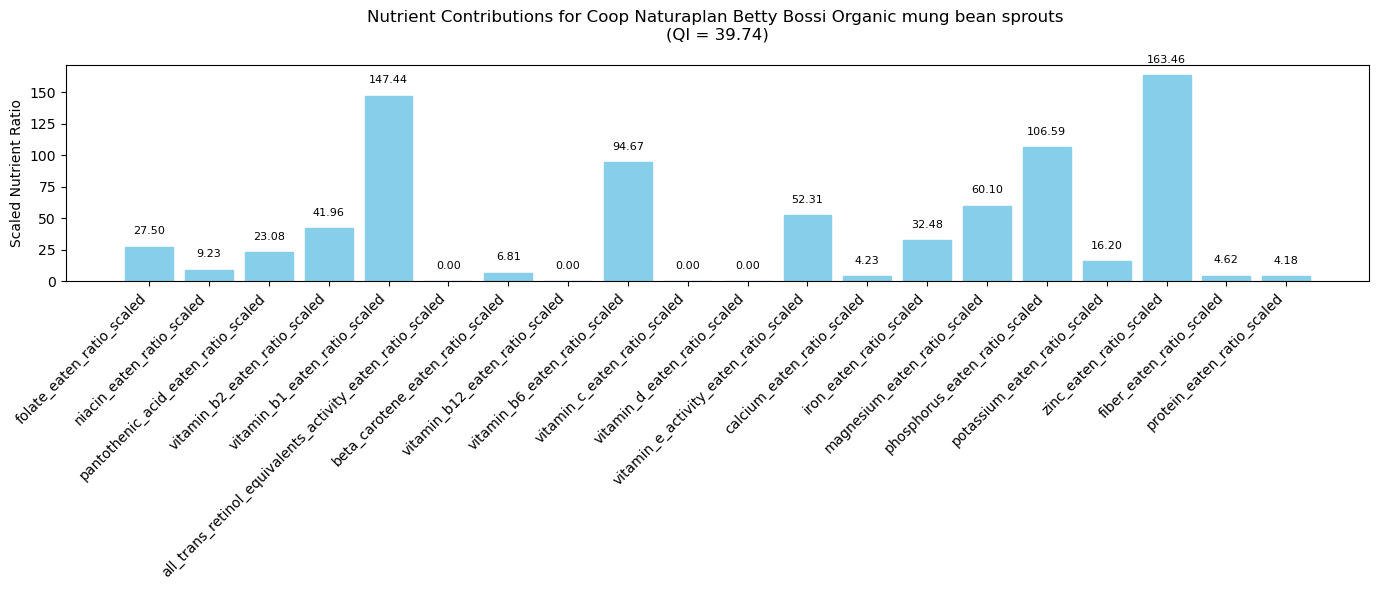

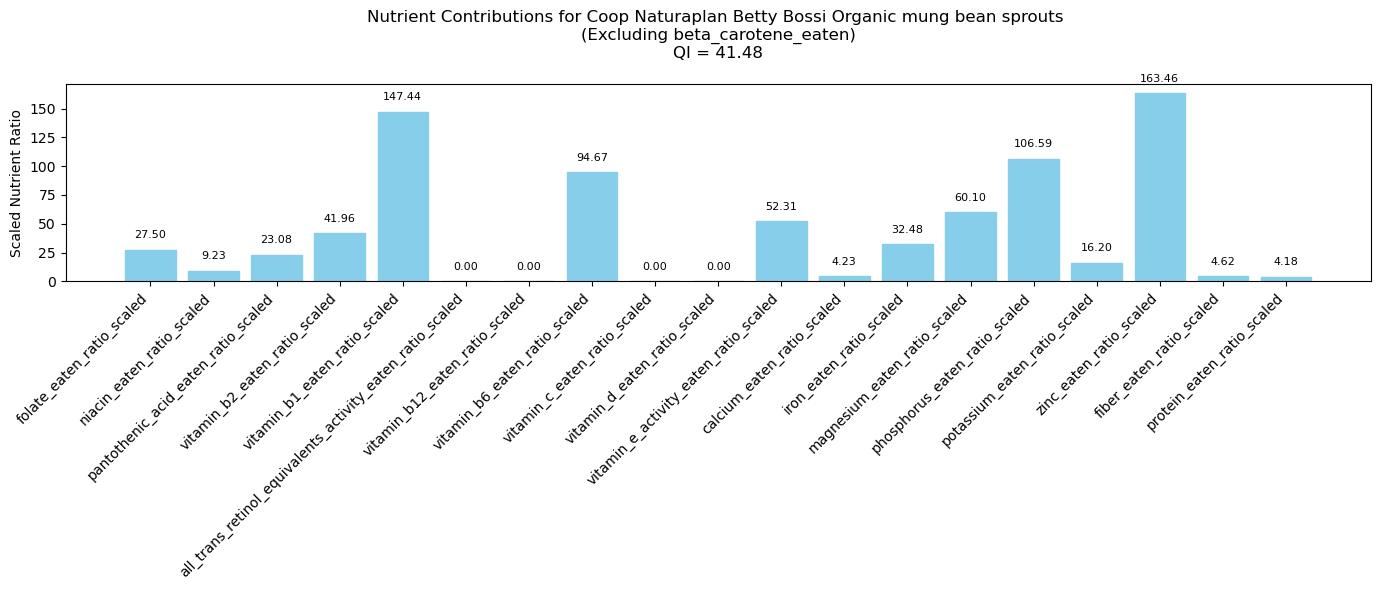

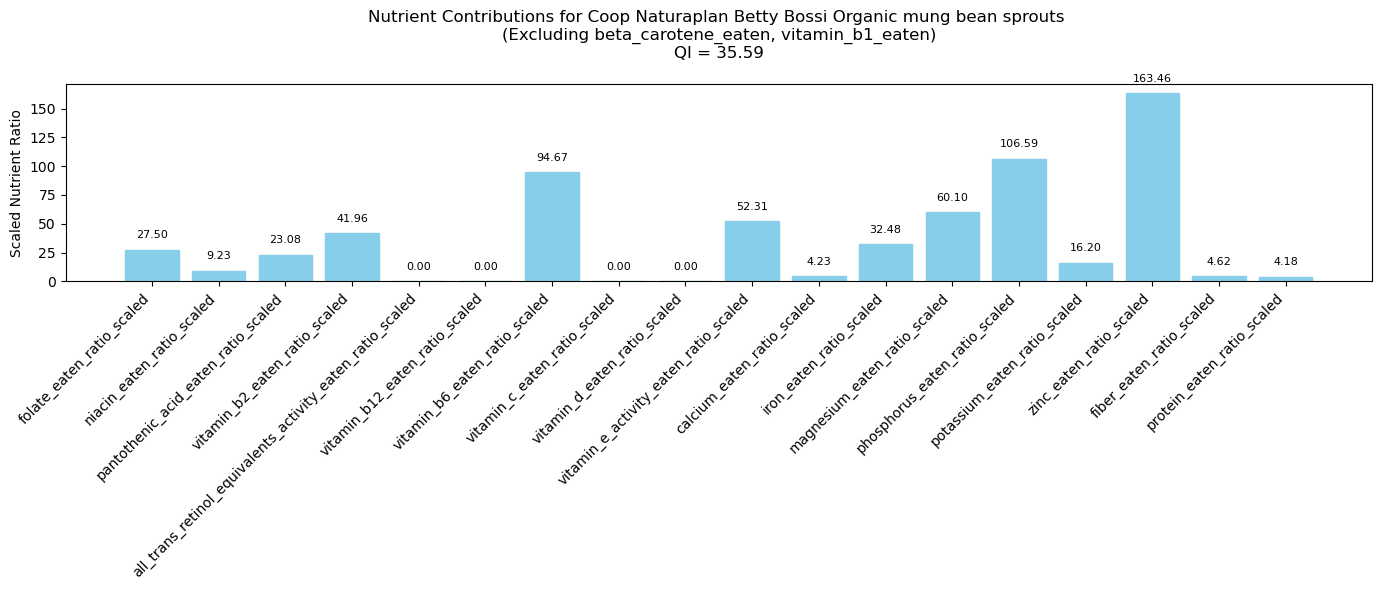

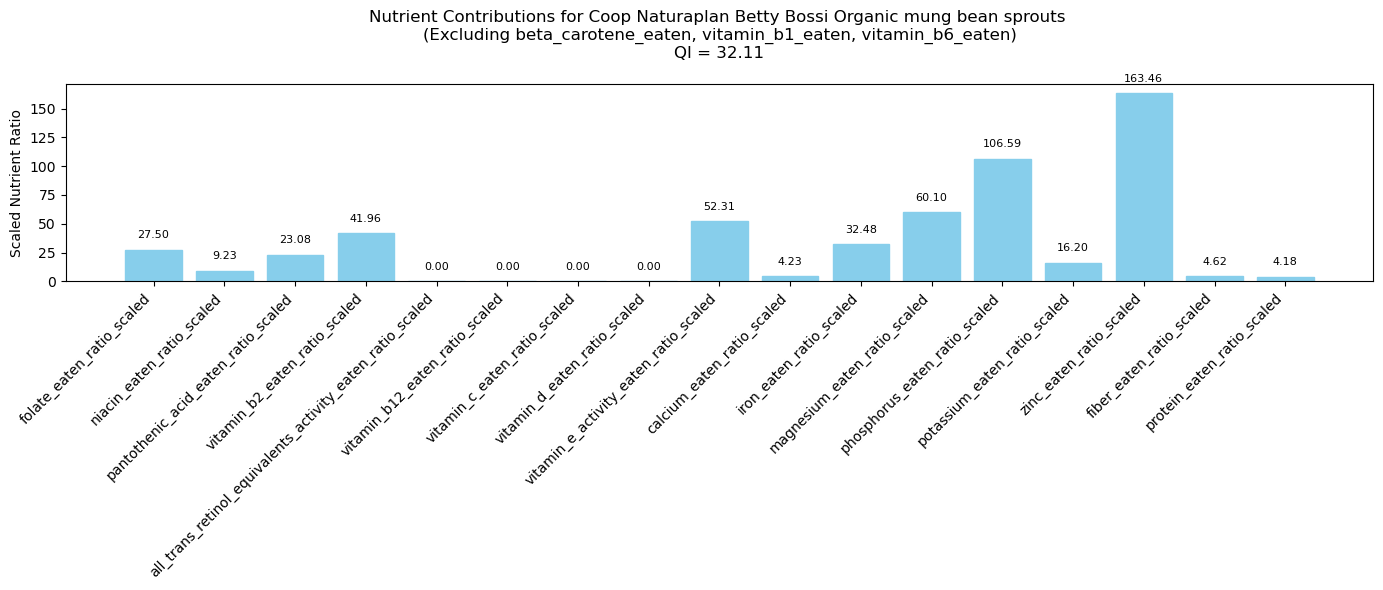

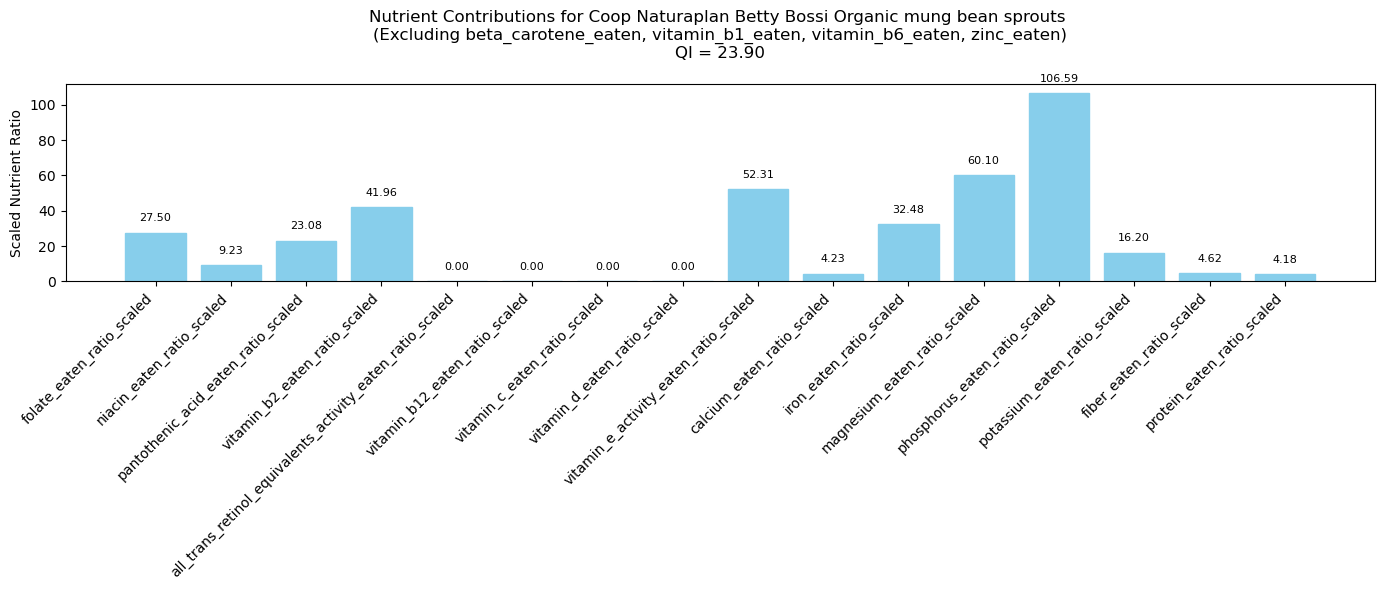

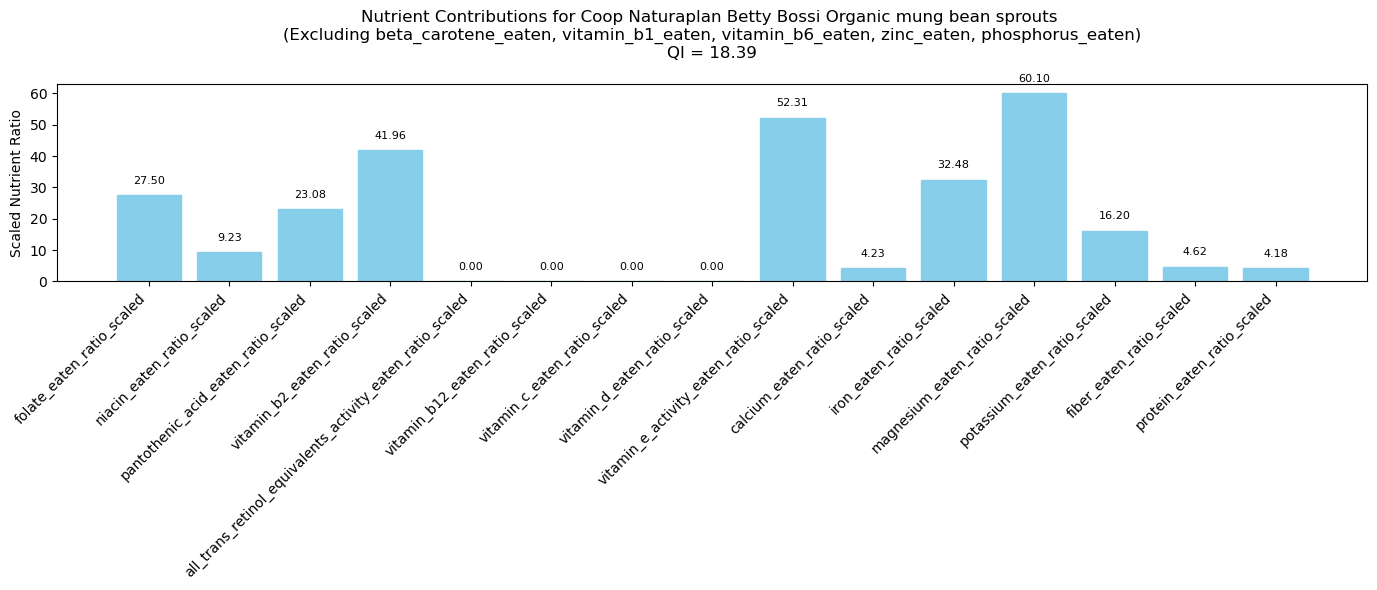

In [79]:
food_item = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Coop Naturaplan Betty Bossi Organic mung bean sprouts'].iloc[0]

plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients)
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten'])
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'vitamin_b1_eaten'])
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'vitamin_b1_eaten', 'vitamin_b6_eaten'])
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'vitamin_b1_eaten', 'vitamin_b6_eaten', 'zinc_eaten'])
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'vitamin_b1_eaten', 'vitamin_b6_eaten', 'zinc_eaten', 'phosphorus_eaten'])

In [80]:
food_item = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Coop Naturaplan Betty Bossi Organic mung bean sprouts'].iloc[0]
qi_including = food_item['QI']
results = []

for nutr in qualifying_nutrients:
    qi_excluding = compute_qi_excluding(food_item, qualifying_nutrients, exclude=nutr, scaling_factor=2000)
    abs_diff = qi_including - qi_excluding
    pct_diff = (abs_diff / qi_including) * 100
    results.append({
        'Nutrient Excluded': nutr,
        'QI (incl.)': qi_including,
        'QI (excl.)': qi_excluding,
        'Absolute Change': abs_diff,
        'Percent Change': pct_diff
    })


df_results = pd.DataFrame(results)
df_results.sort_values('Absolute Change', ascending=False)

,Nutrient Excluded,QI (incl.),QI (excl.),Absolute Change,Percent Change
17,zinc_eaten,39.742825,33.231314,6.511511,16.384118
4,vitamin_b1_eaten,39.742825,34.074769,5.668056,14.261836
15,phosphorus_eaten,39.742825,36.224373,3.518452,8.853049
8,vitamin_b6_eaten,39.742825,36.851681,2.891144,7.274631
14,magnesium_eaten,39.742825,38.671597,1.071228,2.695399
11,vitamin_e_activity_eaten,39.742825,39.081516,0.661309,1.663970
3,vitamin_b2_eaten,39.742825,39.626235,0.116590,0.293362
13,iron_eaten,39.742825,40.125151,-0.382326,-0.962000
0,folate_eaten,39.742825,40.387184,-0.644359,-1.621322
2,pantothenic_acid_eaten,39.742825,40.619978,-0.877153,-2.207072


In [81]:
high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Valenzi Eierschwämme klein'][[i for i in high_qi_vegetable.columns if '_ratio_scaled' in i]].T

,468199
folate_eaten_ratio_scaled,7.500000
niacin_eaten_ratio_scaled,75.000000
pantothenic_acid_eaten_ratio_scaled,83.333333
vitamin_b2_eaten_ratio_scaled,34.848485
vitamin_b1_eaten_ratio_scaled,2.777778
all_trans_retinol_equivalents_activity_eaten_ratio_scaled,0.000000
beta_carotene_eaten_ratio_scaled,167.619048
vitamin_b12_eaten_ratio_scaled,0.000000
vitamin_b6_eaten_ratio_scaled,5.128205
vitamin_c_eaten_ratio_scaled,11.777778


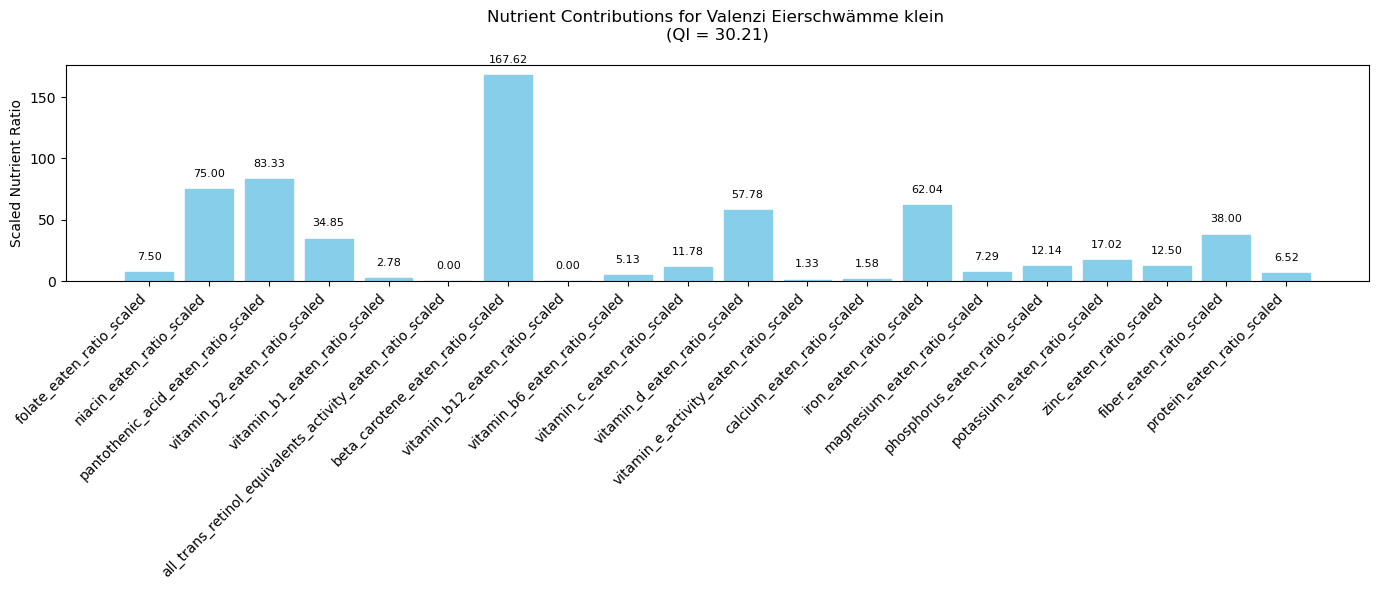

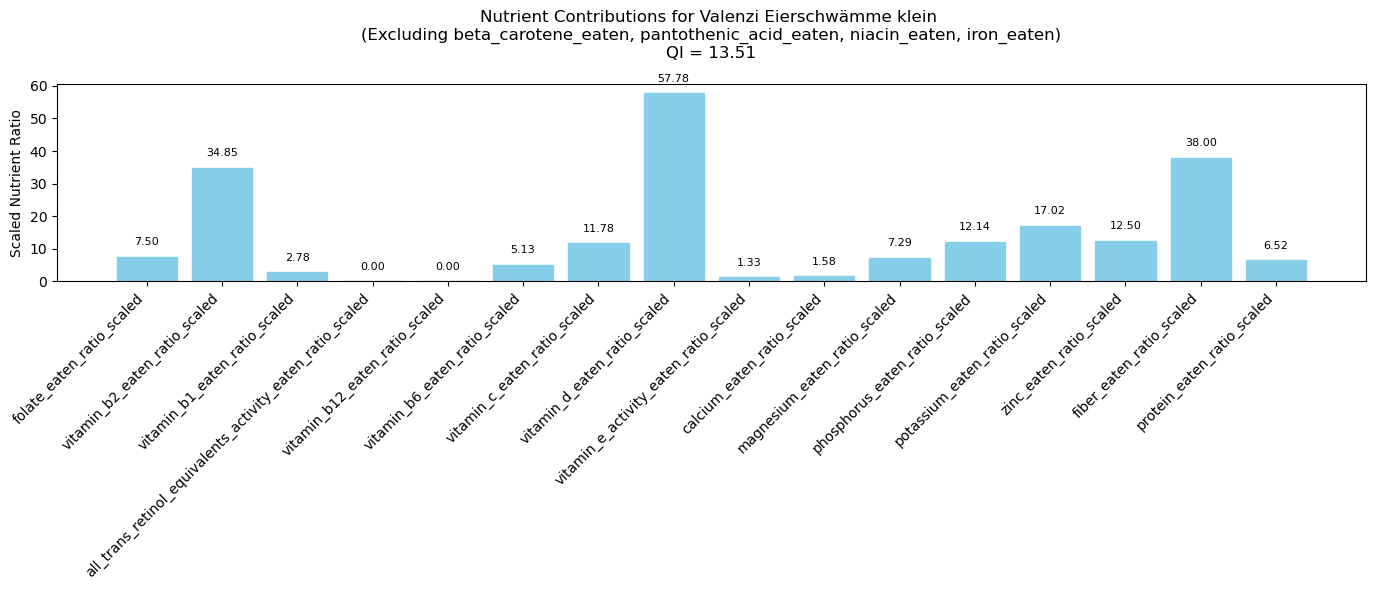

,Nutrient Excluded,QI (incl.),QI (excl.),Absolute Change,Percent Change
6,beta_carotene_eaten,30.209682,22.977611,7.232072,23.939583
2,pantothenic_acid_eaten,30.209682,27.413701,2.795982,9.255250
1,niacin_eaten,30.209682,27.852297,2.357385,7.803409
13,iron_eaten,30.209682,28.534558,1.675124,5.544990
10,vitamin_d_eaten,30.209682,28.758730,1.450952,4.802938
18,fiber_eaten,30.209682,29.799666,0.410017,1.357236
3,vitamin_b2_eaten,30.209682,29.965535,0.244147,0.808176
16,potassium_eaten,30.209682,30.903809,-0.694127,-2.297696
17,zinc_eaten,30.209682,31.141771,-0.932089,-3.085397
15,phosphorus_eaten,30.209682,31.160568,-0.950886,-3.147618


In [82]:
food_item = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Valenzi Eierschwämme klein'].iloc[0]

plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients)
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['beta_carotene_eaten', 'pantothenic_acid_eaten', 'niacin_eaten', 'iron_eaten'])

qi_including = food_item['QI']
results = []

for nutr in qualifying_nutrients:
    qi_excluding = compute_qi_excluding(food_item, qualifying_nutrients, exclude=nutr, scaling_factor=2000)
    abs_diff = qi_including - qi_excluding
    pct_diff = (abs_diff / qi_including) * 100
    results.append({
        'Nutrient Excluded': nutr,
        'QI (incl.)': qi_including,
        'QI (excl.)': qi_excluding,
        'Absolute Change': abs_diff,
        'Percent Change': pct_diff
    })


df_results = pd.DataFrame(results)
df_results.sort_values('Absolute Change', ascending=False)

In [83]:
"""
row = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Valenzi Eierschwämme klein'].iloc[0]

exclude_list = ['beta_carotene_eaten', 'pantothenic_acid_eaten', 'niacin_eaten', 'iron_eaten']

qi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)
print(f"QI excluding {exclude_list}: {qi_excl:.2f}")"
"""

'\nrow = high_qi_vegetable[high_qi_vegetable[\'combined_name\'] == \'Valenzi Eierschwämme klein\'].iloc[0]\n\nexclude_list = [\'beta_carotene_eaten\', \'pantothenic_acid_eaten\', \'niacin_eaten\', \'iron_eaten\']\n\nqi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)\nprint(f"QI excluding {exclude_list}: {qi_excl:.2f}")"\n'

In [84]:
high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Pancho Villa Sliced Jalapeños'][[i for i in high_qi_vegetable.columns if '_ratio_scaled' in i]].T

,465370
folate_eaten_ratio_scaled,0.000000
niacin_eaten_ratio_scaled,89.285714
pantothenic_acid_eaten_ratio_scaled,0.000000
vitamin_b2_eaten_ratio_scaled,128.787879
vitamin_b1_eaten_ratio_scaled,45.138889
all_trans_retinol_equivalents_activity_eaten_ratio_scaled,0.000000
beta_carotene_eaten_ratio_scaled,0.000000
vitamin_b12_eaten_ratio_scaled,0.000000
vitamin_b6_eaten_ratio_scaled,0.000000
vitamin_c_eaten_ratio_scaled,0.000000


In [85]:
row = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Pancho Villa Sliced Jalapeños'].iloc[0]

exclude_list = ['vitamin_b2_eaten', 'iron_eaten', 'niacin_eaten']

qi_excl = compute_qi_excluding_multiple(row, qualifying_nutrients, exclude_list, scaling_factor=2000)
print(f"QI excluding {exclude_list}: {qi_excl:.2f}")

AttributeError: 'dict' object has no attribute 'remove'

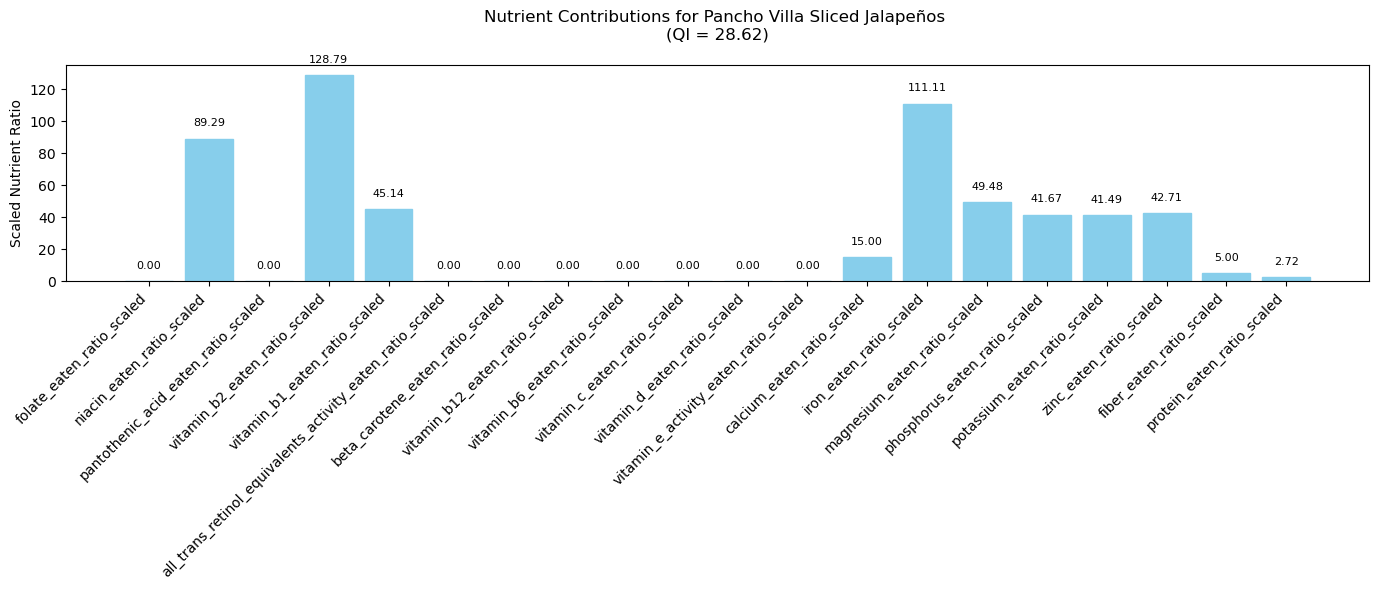

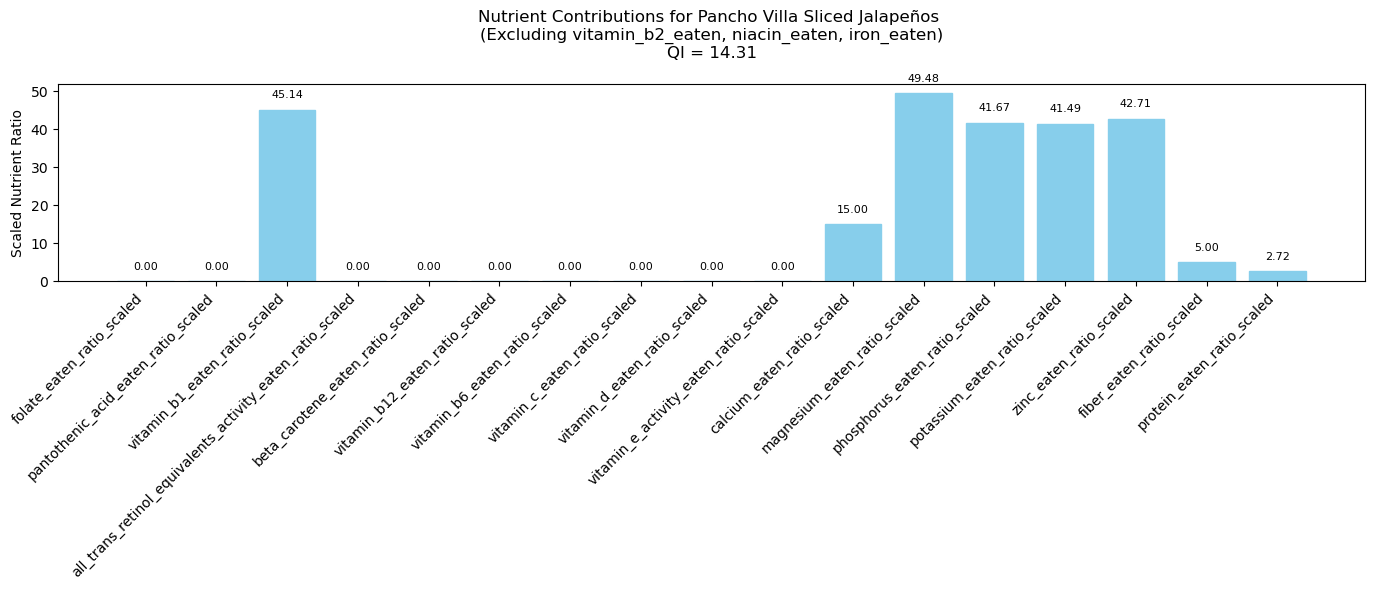

,Nutrient Excluded,QI (incl.),QI (excl.),Absolute Change,Percent Change
3,vitamin_b2_eaten,28.619226,23.347191,5.272034,18.421303
13,iron_eaten,28.619226,24.277547,4.341678,15.170495
1,niacin_eaten,28.619226,25.426253,3.192973,11.156742
14,magnesium_eaten,28.619226,27.521334,1.097892,3.836203
4,vitamin_b1_eaten,28.619226,27.749770,0.869456,3.038014
17,zinc_eaten,28.619226,27.877694,0.741532,2.591027
15,phosphorus_eaten,28.619226,27.932518,0.686707,2.399462
16,potassium_eaten,28.619226,27.941850,0.677376,2.366855
12,calcium_eaten,28.619226,29.336027,-0.716801,-2.504615
18,fiber_eaten,28.619226,29.862343,-1.243117,-4.343644


In [ ]:
food_item = high_qi_vegetable[high_qi_vegetable['combined_name'] == 'Pancho Villa Sliced Jalapeños'].iloc[0]

plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients)
plot_nutrient_contributions_with_qi(food_item, qualifying_nutrients, exclude_list=['vitamin_b2_eaten', 'niacin_eaten', 'iron_eaten'])

qi_including = food_item['QI']
results = []

for nutr in qualifying_nutrients:
    qi_excluding = compute_qi_excluding(food_item, qualifying_nutrients, exclude=nutr, scaling_factor=2000)
    abs_diff = qi_including - qi_excluding
    pct_diff = (abs_diff / qi_including) * 100
    results.append({
        'Nutrient Excluded': nutr,
        'QI (incl.)': qi_including,
        'QI (excl.)': qi_excluding,
        'Absolute Change': abs_diff,
        'Percent Change': pct_diff
    })


df_results = pd.DataFrame(results)
df_results.sort_values('Absolute Change', ascending=False)